<center>Национальный исследовательский университет ИТМО<br/>Факультет информационных технологий и программирования<br/>Прикладная математика и информатика</center>


## <center>Методы оптимизации</center>

### <center>Отчёт по лабораторной работе №1</center>

<div style="text-align: right"><b>Работу выполнили:</b><br/>Салахов Камиль M33381<br/>Мухтаров Айнур M33371<br/></div>

<center>Санкт-Петербург<br/>2023</center>

## Задача

1. Реализуйте градиентный спуск с постоянным шагом (learning rate).
2. Реализуйте метод одномерного поиска (метод дихотомии, метод Фибоначчи, метод золотого сечения) и градиентный спуск на его основе.
3. Проанализируйте траекторию градиентного спуска на примере квадратичных функций. Для этого придумайте две-три квадратичные функции от двух переменных, на которых работа методов будет отличаться.
4. Для каждой функции
4.1. исследуйте сходимость градиентного спуска с постоянным шагом, сравните полученные результаты для выбранных функций;
4.2. сравните эффективность градиентного спуска с использованием одномерного поиска с точки зрения количества вычислений минимизируемой функции и ее градиентов;
4.3. исследуйте работу методов в зависимости от выбора начальной точки;
4.4. исследуйте влияние нормализации (scaling) на сходимость на примере масштабирования осей плохо обусловленной функции;
4.5. в каждом случае нарисуйте графики с линиями уровня и траекториями методов;
5. Реализуйте генератор случайных квадратичных функций n переменных с числом обусловленности k.
6. Исследуйте зависимость числа итераций $T(n,k)$, необходимых градиентному спуску для сходимости в зависимости от размерности пространства $2 ≤ n ≤ 10^3$ и числа обусловленности оптимизируемой функции $1 ≤ k ≤ 10^3$.
7. Для получения более корректных результатов проведите множественный эксперимент и усредните полученные значения числа итераций.
8. Реализуйте одномерный поиск с учетом условий Вольфе и исследуйте его эффективность. Сравните полученные результаты с реализованными ранее методами.

## Общее

In [144]:
import numpy as np  # для многомерных массивов

Хотим уметь подсчитывать количество вычислений функции и её производной. Для этого напишем обёртку над нашими функциями, которая будет вычислять это:

In [145]:
NEED_TO_COUNT_CALLS = True  # иногда не хотим считать какие-то вызовы. Тогда просто убираем флаг


class CleverFunction:
    def __init__(self, func):
        self.func = func
        self.function_calls_count = 0
        self.gradient_calls_count = 0

    def __call__(self, *args, **kwargs):  # вызывается при каждом вызове функции
        global NEED_TO_COUNT_CALLS

        if NEED_TO_COUNT_CALLS:
            self.function_calls_count += 1

        return self.func(*args, **kwargs)

    def get_gradient(self, x):  # вызываем для поиска производной
        global NEED_TO_COUNT_CALLS

        if NEED_TO_COUNT_CALLS:
            self.gradient_calls_count += 1

        return gradient(self.func, x)

    def clear(self):  # сбрасываем счётчики (если хотим одну и ту же функцию потестить несколько раз)
        self.function_calls_count = 0
        self.gradient_calls_count = 0

    def get_info(self):  # просто возвращаем счётчики
        return self.function_calls_count, self.gradient_calls_count


def clever(func):  # простейший конструктор. Можно делать красиво с помощью аннотаций @clever
    return CleverFunction(func)

# 1. Реализуйте градиентный спуск с постоянным шагом (learning rate).

## Вычисление градиента

Для численного представления градиента (мы не умеем явно находить градиент для любой функции) будем использовать формулу центральной разности:

 $\nabla f(x)=\begin{pmatrix}\frac{f(x_1 + \varepsilon, x_2, \ldots, x_n)}{2\cdot\varepsilon}\\\frac{f(x_1, x_2 + \varepsilon, \ldots, x_n)}{2\cdot\varepsilon}\\\vdots\\\frac{f(x_1, x_2, \ldots, x_n + \varepsilon)}{2\cdot\varepsilon}\end{pmatrix} - \begin{pmatrix}\frac{f(x_1 - \varepsilon, x_2, \ldots, x_n)}{2\cdot\varepsilon}\\\frac{f(x_1, x_2 - \varepsilon, \ldots, x_n)}{2\cdot\varepsilon}\\\vdots\\\frac{f(x_1, x_2, \ldots, x_n - \varepsilon)}{2\cdot\varepsilon}\end{pmatrix}$

 , где $\varepsilon$ - некое достаточно маленькое число (такое, чтобы было достаточно точно и при этом было машинно-представимо)
 Возьмём $\varepsilon = 2 * 10^{-8}$


In [147]:
EPS = 2 * 1e-8


def gradient(function, x):
    # если получили обёртку над нашей функцией, то необходимо вызвать метод get_gradient(), чтобы честно посчитать производную (и не забыть посчитать вызов)
    if isinstance(function, CleverFunction):
        return function.get_gradient(x)
    else:  # иначе просто считаем по формуле
        left = function(x[:, np.newaxis] - EPS * np.eye(x.shape[0]))  # left matrix
        right = function(x[:, np.newaxis] + EPS * np.eye(x.shape[0]))  # right matrix

    return (right - left) / (2 * EPS)

## Градиентный спуск

Метод градиентного спуска с постоянным шагом - это способ нахождения минимума функции. Он работает так: мы начинаем с какого-то значения параметра и потом на каждом шаге обновляем его, двигаясь в направлении, противоположном градиенту функции. Градиент - это показатель направления наискорейшего возрастания функции потерь.

Чтобы обновить параметр, мы вычитаем из его текущего значения произведение градиента и некоторого шага (learning rate). Шаг обновления определяет, насколько сильно параметры изменятся на каждой итерации. Если шаг слишком большой, мы можем не достичь минимума и расходиться. А если слишком маленький, мы будем сходиться очень медленно.

Мы продолжаем обновлять параметры до тех пор, пока не достигнем условия остановки, например, заданного количества итераций или достаточно маленького изменения функции потерь.

Этот метод - один из самых простых и популярных способов оптимизации. Однако у него есть некоторые проблемы, такие как затухание градиента и застревание в локальных минимумах. Есть и другие методы градиентного спуска, которые пытаются решить эти проблемы, например, методы с адаптивным шагом или использование момента.

Реализуем его, передавая в качестве параметров:
1. function - саму функцию
2. dims_count - кол-во измерений (для генерации начальной точки, если она нам не известна)
3. start_point - начальную точку (если известна)
4. gradient_function - градиент функции, если он нам известен (иначе используем просто метод gradient())
5. constant_step - шаг градиента (возьмём в качестве начального значения 0.05)
6. iteration_count - количество итераций градиентного спуска (в качестве начального значения – 50)

Так же напишем три простейшие вспомогательные функции, которые нам понадобятся в дальнейшем:

In [148]:
RANDOM_SEED = 100  # просто число из головы
np.random.seed(RANDOM_SEED)  # установим seed, чтобы всегда получать одинаковые значения (легче дебажить)


def get_start_point(start_point, dims_count):  # если точки нет - генерируем
    return np.random.rand(dims_count) if (start_point is None) else start_point


def get_gradient_function(function, gradient_function):  # если градиента нет - используем функцию gradient()
    return (lambda x: gradient(function, x)) if (gradient_function is None) else gradient_function


MINIMUM_EPS = 1e-5


def is_minimum_found(function, real_minimum, x):  # для тестов, чтобы уметь проверять сходимость
    global NEED_TO_COUNT_CALLS
    NEED_TO_COUNT_CALLS = False  # не хотим считать вызовы функции при проверке, нашли ли минимум
    minimum_found = real_minimum is not None and np.abs(function(x) - real_minimum) < MINIMUM_EPS
    NEED_TO_COUNT_CALLS = True
    return minimum_found


In [6]:
CONSTANT_GRADIENT_DESCENT_NAME = "Constant gradient descent"


def constant_gradient_descent(function, dims_count, start_point=None, gradient_function=None, constant_step=0.05,
                              iteration_count=50, real_minimum=None):
    start_point = get_start_point(start_point, dims_count)
    gradient_function = get_gradient_function(function, gradient_function)

    x = start_point
    xs = [x]  # посещенные в процессе градиентного спуска точки

    for _ in range(iteration_count):
        grad = gradient_function(x)
        x = x - grad * constant_step  # смещаемся в направлении антиградиента
        xs.append(x)  # добавляем точку в посещенные

        if is_minimum_found(function, real_minimum, x):
            break

    return xs

# 2. Реализуйте метод одномерного поиска (метод Фибоначчи)

Метод поиска минимума по направлению с помощью метода Фибоначчи - это способ нахождения оптимального шага при градиентном спуске. Он работает так: мы выбираем начальный интервал, в котором будем искать оптимальный шаг, и делим его на две части с помощью чисел Фибоначчи. Затем мы сравниваем значения функции потерь в точках, соответствующих концам этих частей, и выбираем новый интервал таким образом, чтобы в нем находился минимум функции. Мы продолжаем делить интервалы до тех пор, пока не достигнем требуемой точности. Этот метод позволяет найти оптимальный шаг, который помогает быстрее достичь минимума функции.

Конкретнее:
Пусть мы хотим найти минимум некой функции $f$ в направлении вектора $\vec{h}$ от точки $x_0$. Тогда введём функцию
$g(t) = f(x_0 + t * \vec{h})$,
минимум которой мы хотим найти на некотором отрезке $[a, b]$
Начальные точки для алгоритма берём в соответствие с методом Фибоначчи:
$l=a + \frac{F_{n-2}}{F_n}\cdot(b - a)$
$r = a + \frac{F_{n-1}}{F_n}\cdot(b - a)$

Рассмотрим $i$ итерацию:

Если $g(l) < g(r)$
$a_{new} = a$
$b_{new} = r$
$l_{new} = a_{new} + \frac{F_{n - i - 2}}{F_{n - i}}\cdot(b_{new} - a_{new})$ – обновляем точку
$r_{new} = l$ – используем в качестве новой точки старую, для уменьшения кол-ва подсчёта функции (для этого и нужен метод Фибоначчи)

Если $g(l) > g(r)$
$a_{new} = l$
$b_{new} = b$
$l_{new} = l$ – используем в качестве новой точки старую, для уменьшения кол-ва подсчёта функции (для этого и нужен метод Фибоначчи)
$r_{new} = a_{new} + \frac{F_{n - i - 1}}{F_{n - i}}\cdot(b_{new} - a_{new})$ – обновляем точку

Напишем простейшую функцию для вычисления чисел Фибоначчи:

In [7]:
fibonacci = [1, 1]


def count_needed_fibonacci(interval, eps):
    global fibonacci

    while interval / fibonacci[-1] > eps:
        fibonacci.append(fibonacci[-1] + fibonacci[-2])

Две простые функции для вычисления левой и правой точки для посчёта функции в методе Фибоначчи:

In [8]:
def get_left_bound_fibonacci(a, b, i):
    return a + fibonacci[i - 2] / fibonacci[i] * (b - a)


def get_right_bound_fibonacci(a, b, i):
    return a + fibonacci[i - 1] / fibonacci[i] * (b - a)

И сам метод поиска минимума по направлению:

In [9]:
LINEAR_GRADIENT_DESCENT_NAME = "Linear gradient descent"


def linear_fibonacci_search(function, start_point, h, interval=1, eps=1e-4):
    global fibonacci
    count_needed_fibonacci(interval, eps)

    num_steps = len(fibonacci) - 1

    a = 0
    b = max(interval, 1)

    l = get_left_bound_fibonacci(a, b, num_steps)
    r = get_right_bound_fibonacci(a, b, num_steps)

    # на первый итерации приходится посчитать значения в обеих точках, после – только в одной
    fl = function(start_point + l * h)
    fr = function(start_point + r * h)

    for i in range(1, num_steps - 1):
        if fl < fr:
            b = r
            r = l
            l = get_left_bound_fibonacci(a, b, num_steps - i)
            fr = fl
            fl = function(start_point + l * h)
        else:
            a = l
            l = r
            r = get_right_bound_fibonacci(a, b, num_steps - i)
            fl = fr
            fr = function(start_point + r * h)

    return start_point + h * (a + b) / 2

Теперь реализуем абстрактный градиентный спуск, который параметризуется методом выбора точки:

In [149]:
def abstract_linear_search(linear_search_type, function, dims_count, gradient_function=None, start_point=None,
                           iteration_count=50, real_minimum=None):
    gradient_function = get_gradient_function(function, gradient_function)

    x = get_start_point(start_point, dims_count)
    xs = [x]
    for _ in range(iteration_count):
        gradient_value = gradient_function(x)

        gradient_norm = np.linalg.norm(gradient_value)

        if abs(gradient_norm) < EPS:
            break

        gradient_value /= -gradient_norm

        x = linear_search_type(function, x, gradient_value, interval=gradient_norm)
        xs.append(x)

        if is_minimum_found(function, real_minimum, x):
            break

    return xs

На основе абстрактного градиентного спуска и метода поиска Фибоначчи, реализуем градиентный спуск, использующий метод Фибоначчи:

In [150]:
def linear_search_gradient_descent(function, dims_count, gradient_function=None, start_point=None, iteration_count=50,
                                   real_minimum=None):
    return abstract_linear_search(linear_fibonacci_search, function, dims_count, gradient_function, start_point,
                                  iteration_count, real_minimum)

# 3. Проанализируйте траекторию градиентного спуска на примере квадратичных функций


## Общий код для тестов

Подключим библиотеки для работы с данными и выводом графиков:

In [151]:
import pandas as pd  # для работы с данными
import matplotlib.pyplot as plt  # для графиков

Для простоты тестирования добавим функцию, которая для каждой тестовой функции будет инициализировать константы:

In [251]:
def init_function(function, real_minimum, function_id):
    global MINIMUM_X, REAL_MINIMUM, CLOSE_POINT, FAR_POINT, FUNCTION_ID, DEFAULT_START_POINT

    MINIMUM_X = real_minimum
    REAL_MINIMUM = function(MINIMUM_X)
    function.clear()
    CLOSE_POINT = MINIMUM_X + np.array([0.5, 0.5])
    DEFAULT_START_POINT = CLOSE_POINT + 10 * np.random.rand(2)
    FAR_POINT = MINIMUM_X + np.array([200, 200])
    FUNCTION_ID = function_id


Используем датафрейм для хранения результатов экспериментов:

In [318]:
df = pd.DataFrame(
    columns=["Function", "Linear search type", "Addition", "Function calls", "Gradient calls", "Summary calls"])

START_POINT_WORD = "Choose start point"
NORMALIZING_WORD = "Normalising"
DEFAULT_START_POINT = 2 * np.random.rand(2)

Добавим простую функцию, которая будет получать результат нужного нам градиентного спуска (с постоянным шагом или на основе метода Фибоначчи):

In [400]:
def get_gradient_descent_result(count_calls_function, gradient_descent_type, start_point, constant_step,
                                iteration_count, real_minimum):
    if constant_step is None:
        return np.array(
            gradient_descent_type(count_calls_function, 2, start_point=start_point, iteration_count=iteration_count,
                                  real_minimum=real_minimum))
    return np.array(
        gradient_descent_type(count_calls_function, 2, constant_step=constant_step, start_point=start_point,
                              iteration_count=iteration_count, real_minimum=real_minimum))

Напишем сам код для тестов. В него будем передавать функцию, нужный метод градиентного спуска, начальную точку, шаг (в случае, если используем градиентный спуск с постоянным методом шагом), нормализацию (расширение/сужение оси) и минимум функции (только для тестов, в обычном режиме - None):

In [401]:
NUM_COUNT = 1000


def test(function, gradient_descent_type, gradient_descent_type_name, graphic_x, graphic_y, additional="", start_point=DEFAULT_START_POINT, constant_step=None, x_scale=1, iteration_count=300, real_minimum=None):
    global FUNCTION_ID

    call_num = len(df)

    @clever
    def count_calls_function(x):  # оборачиваем для подсчёта кол-ва вызовов
        return function(x * np.array([x_scale, 1]))  # масштабируем, если нужно

    count_calls_function.clear()

    start_point = get_start_point(start_point, 2)

    xs = get_gradient_descent_result(count_calls_function, gradient_descent_type, start_point, constant_step, iteration_count, real_minimum)

    all_calls = count_calls_function.get_info()

    print(f"{gradient_descent_type_name}. Start point is {start_point}, finish point is {np.round(xs[-1], 2)},"
          f" diff with real minimum {np.round(MINIMUM_X - xs[-1]*x_scale, 2)}, using scale = {x_scale}. Function calls count = {all_calls[0]}. Gradient calls count = {all_calls[1]}")

    df.loc[str(call_num)] = [FUNCTION_ID, gradient_descent_type_name, additional, all_calls[0], all_calls[1], all_calls[0] + 2 * 2 * all_calls[1]]

    plt.plot(xs[:, 0], xs[:, 1], 'o-')

    x_line = np.linspace(graphic_x[0], graphic_x[1], NUM_COUNT)
    y_line = np.linspace(graphic_y[0], graphic_y[1], NUM_COUNT)
    X, Y = np.meshgrid(x_line, y_line)

    levels = np.unique([count_calls_function(np.array([x[0], x[1]])) for x in xs])
    plt.contour(X, Y, function(np.array([X * x_scale, Y])), levels=levels)

Так же добавим метод, который запускает сразу 8 тестов для функции (обычный, удаление/приближение, нормализация для всех методов):

In [402]:
def run_all(function):
    global NORMALIZING_WORD

    test(function, constant_gradient_descent, CONSTANT_GRADIENT_DESCENT_NAME, -100, 100, constant_step=0.025,
         real_minimum=REAL_MINIMUM)
    test(function, linear_search_gradient_descent, LINEAR_GRADIENT_DESCENT_NAME, -100, 100, real_minimum=REAL_MINIMUM)
    test(function, constant_gradient_descent, CONSTANT_GRADIENT_DESCENT_NAME, -100, 100, constant_step=0.025,
         real_minimum=REAL_MINIMUM, start_point=CLOSE_POINT)
    test(function, constant_gradient_descent, CONSTANT_GRADIENT_DESCENT_NAME, -100, 100, constant_step=0.025,
         real_minimum=REAL_MINIMUM, start_point=FAR_POINT)
    test(function, linear_search_gradient_descent, LINEAR_GRADIENT_DESCENT_NAME, -100, 100, real_minimum=REAL_MINIMUM,
         start_point=CLOSE_POINT)
    test(function, linear_search_gradient_descent, LINEAR_GRADIENT_DESCENT_NAME, -100, 100, real_minimum=REAL_MINIMUM,
         start_point=FAR_POINT)
    test(function, constant_gradient_descent, CONSTANT_GRADIENT_DESCENT_NAME, -100, 100, additional=NORMALIZING_WORD,
         x_scale=5, constant_step=0.01, real_minimum=REAL_MINIMUM)
    test(function, linear_search_gradient_descent, LINEAR_GRADIENT_DESCENT_NAME, -100, 100, additional=NORMALIZING_WORD,
         x_scale=5, real_minimum=REAL_MINIMUM)

## Первая функция

$f_1(x, y) = x^2 + 30y^2$

Минимум достигается в точке $(0, 0)$
Число обусловленности = $\frac{30}{1} = 30$

In [403]:
FIRST_FUNCTION_MINIMUM_X = np.array([0, 0])


@clever
def first_function(x):
    return x[0] ** 2 + 30 * x[1] ** 2


init_function(first_function, FIRST_FUNCTION_MINIMUM_X, 1)

Constant gradient descent. Start point is [3.63066442 6.84036683], finish point is [ 0. -0.], diff with real minimum [-0.  0.], using scale = 1. Function calls count = 0. Gradient calls count = 138


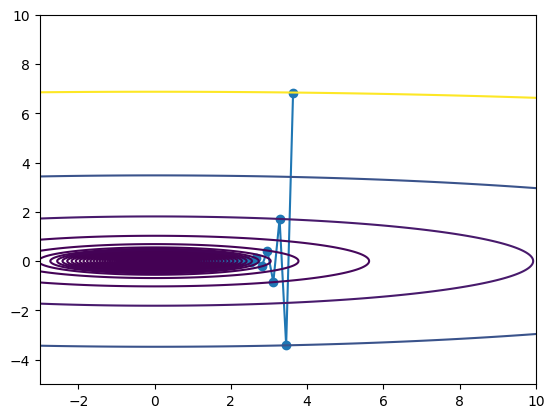

In [404]:
test(first_function, constant_gradient_descent, CONSTANT_GRADIENT_DESCENT_NAME, [-3, 10], [-5, 10], constant_step=0.025, real_minimum=REAL_MINIMUM)

Linear gradient descent. Start point is [3.63066442 6.84036683], finish point is [0. 0.], diff with real minimum [-0. -0.], using scale = 1. Function calls count = 160. Gradient calls count = 4


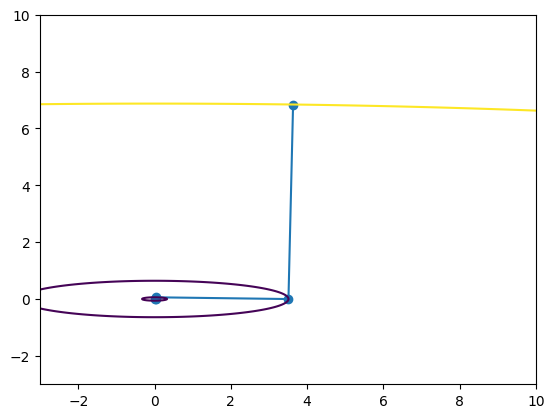

In [405]:
test(first_function, linear_search_gradient_descent, LINEAR_GRADIENT_DESCENT_NAME, [-3, 10], [-3, 10], real_minimum=REAL_MINIMUM)

Попробуем сместить начальную точку ближе/дальше к точке минимума

Constant gradient descent. Start point is [0.5 0.5], finish point is [0. 0.], diff with real minimum [-0. -0.], using scale = 1. Function calls count = 0. Gradient calls count = 99


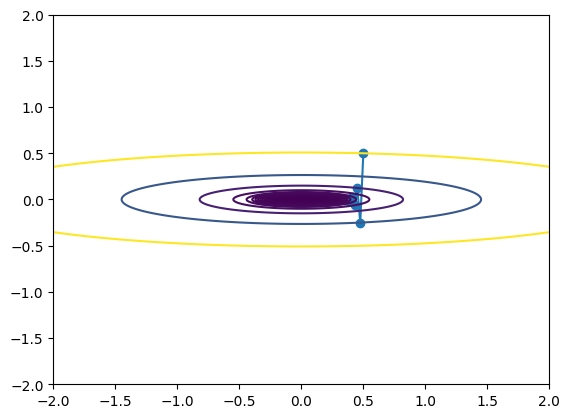

In [406]:
test(first_function, constant_gradient_descent, CONSTANT_GRADIENT_DESCENT_NAME, [-2, 2], [-2, 2], constant_step=0.025, real_minimum=REAL_MINIMUM, start_point=CLOSE_POINT)

Constant gradient descent. Start point is [200 200], finish point is [0. 0.], diff with real minimum [-0. -0.], using scale = 1. Function calls count = 0. Gradient calls count = 216


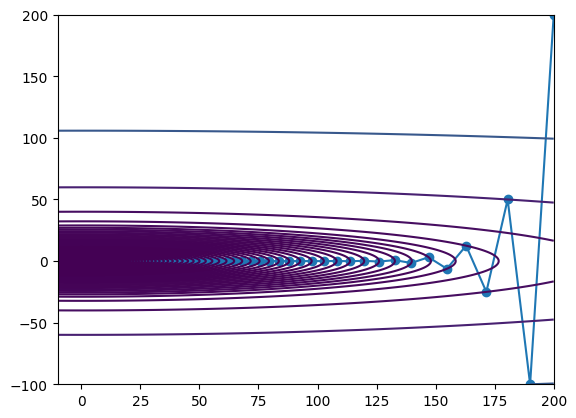

In [407]:
test(first_function, constant_gradient_descent, CONSTANT_GRADIENT_DESCENT_NAME, [-10, 200], [-100, 200], constant_step=0.025, real_minimum=REAL_MINIMUM, start_point=FAR_POINT)

Аналогично рассмотрим поведение градиентного спуска на основе метода Фибоначчи с близкой/далёкой от минимума точкой:

Linear gradient descent. Start point is [0.5 0.5], finish point is [0. 0.], diff with real minimum [-0. -0.], using scale = 1. Function calls count = 160. Gradient calls count = 4


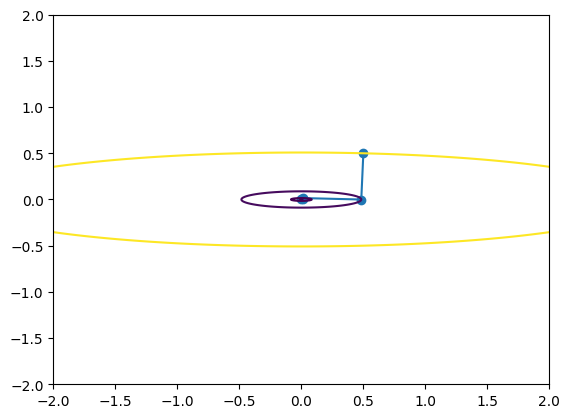

In [408]:
test(first_function, linear_search_gradient_descent, LINEAR_GRADIENT_DESCENT_NAME, [-2, 2], [-2, 2], real_minimum=REAL_MINIMUM, start_point=CLOSE_POINT)

Linear gradient descent. Start point is [200 200], finish point is [0. 0.], diff with real minimum [-0. -0.], using scale = 1. Function calls count = 320. Gradient calls count = 8


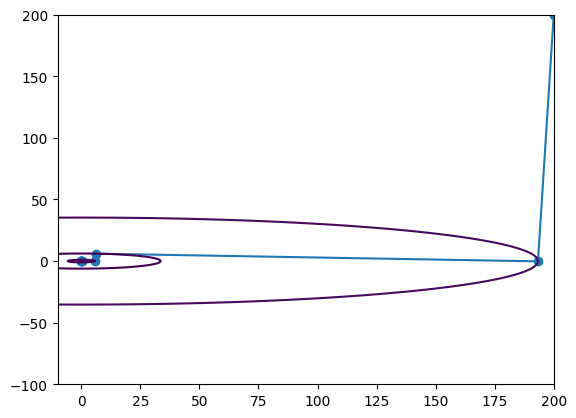

In [409]:
test(first_function, linear_search_gradient_descent, LINEAR_GRADIENT_DESCENT_NAME, [-10, 200], [-100, 200], real_minimum=REAL_MINIMUM, start_point=FAR_POINT)

### Выводы по сближению/удалению начальной точки от точки минимума

Вполне логично, что чем дальше начальная точка от точки минимума, тем больше вычислений функции/градиента необходимо для приближения к точке минимума.
Более того, видно, что градиентный спуск на основе метода Фибоначчи при удалении начальной точки от точки минимума требует меньше вычислений, чем градиентный спуск с постоянным шагом

### Нормализация

Constant gradient descent. Start point is [3.63066442 6.84036683], finish point is [0. 0.], diff with real minimum [-0. -0.], using scale = 5.477225575051661. Function calls count = 0. Gradient calls count = 11


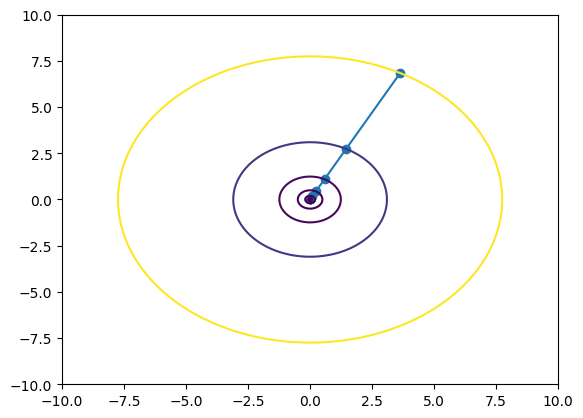

In [413]:
test(first_function, constant_gradient_descent, CONSTANT_GRADIENT_DESCENT_NAME, [-10, 10], [-10, 10], additional=NORMALIZING_WORD, x_scale=np.sqrt(30), constant_step=0.01, real_minimum=REAL_MINIMUM)

Linear gradient descent. Start point is [3.63066442 6.84036683], finish point is [0. 0.], diff with real minimum [-0. -0.], using scale = 5.477225575051661. Function calls count = 40. Gradient calls count = 1


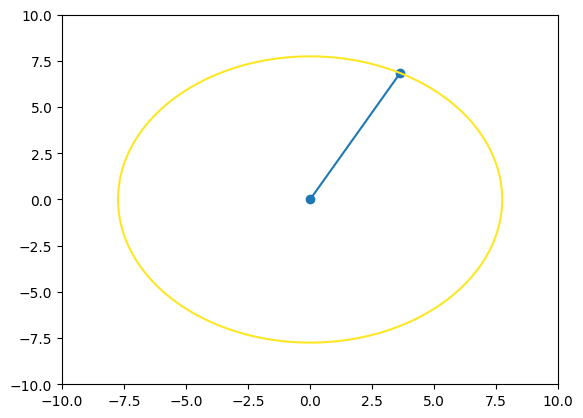

In [412]:
test(first_function, linear_search_gradient_descent, LINEAR_GRADIENT_DESCENT_NAME, [-10, 10], [-10, 10], additional=NORMALIZING_WORD, x_scale=np.sqrt(30), real_minimum=REAL_MINIMUM)

### Выводы по нормализации
Видно, что в данном случае нормализация помогла уменьшить кол-во вычислений как для градиентного спуска с постоянным шагом, так и для градиентного спуска на основе метода Фибоначчи

## Вторая функция

$f_2(x, y)=4(x - 100)^2 + 0.9(y - 150)^2$

Минимум достигается в точке $(100, 150)$

Число обусловленности $\frac{4}{0.9} = 4.(44)$

In [414]:
SECOND_FUNCTION_MINIMUM_X = np.array([100, 150])


@clever
def second_function(x):
    return 4 * (x[0] - 100) * (x[0] - 100) + 0.9 * (x[1] - 150) * (x[1] - 150)


init_function(second_function, SECOND_FUNCTION_MINIMUM_X, 2)

Constant gradient descent. Start point is [3.63066442 6.84036683], finish point is [100. 150.], diff with real minimum [0. 0.], using scale = 1. Function calls count = 0. Gradient calls count = 300


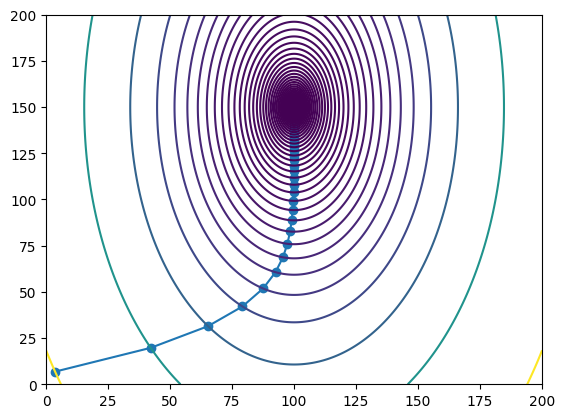

In [415]:
test(second_function, constant_gradient_descent, CONSTANT_GRADIENT_DESCENT_NAME, [0, 200], [0, 200], constant_step=0.05)

Linear gradient descent. Start point is [3.63066442 6.84036683], finish point is [100. 150.], diff with real minimum [0. 0.], using scale = 1. Function calls count = 12000. Gradient calls count = 300


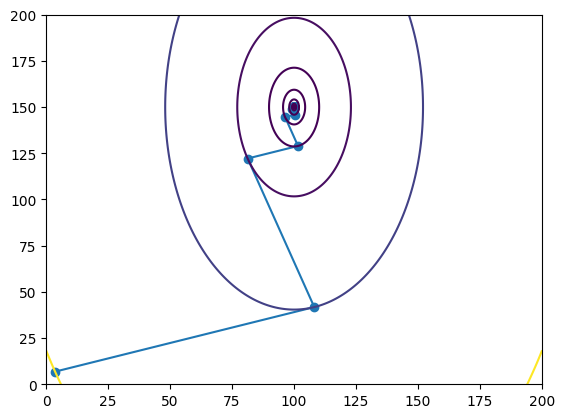

In [416]:
test(second_function, linear_search_gradient_descent, LINEAR_GRADIENT_DESCENT_NAME, [0, 200], [0, 200])

Попробуем сместить начальную точку ближе/дальше к точке минимума

Constant gradient descent. Start point is [100.5 150.5], finish point is [100. 150.], diff with real minimum [-0. -0.], using scale = 1. Function calls count = 0. Gradient calls count = 109


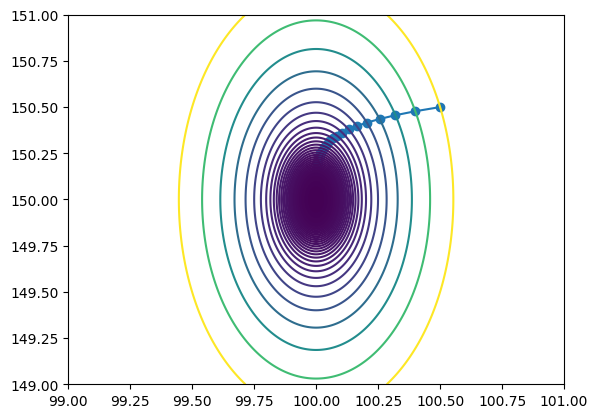

In [418]:
test(second_function, constant_gradient_descent, CONSTANT_GRADIENT_DESCENT_NAME, [99, 101], [149, 151], constant_step=0.025,
     real_minimum=REAL_MINIMUM, start_point=CLOSE_POINT)

Constant gradient descent. Start point is [300 350], finish point is [100. 150.], diff with real minimum [ 0. -0.], using scale = 1. Function calls count = 0. Gradient calls count = 239


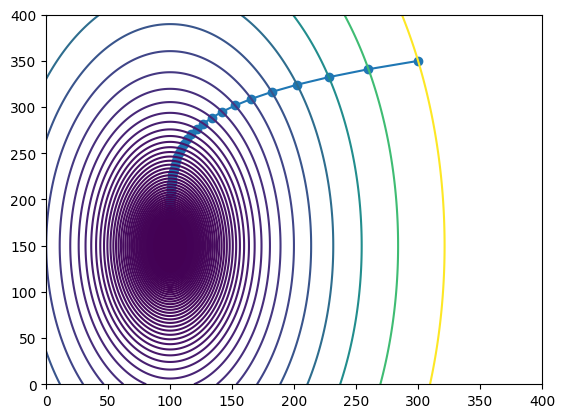

In [419]:
test(second_function, constant_gradient_descent, CONSTANT_GRADIENT_DESCENT_NAME, [0, 400], [0, 400], constant_step=0.025,
     real_minimum=REAL_MINIMUM, start_point=FAR_POINT)

Аналогично рассмотрим поведение градиентного спуска на основе метода Фибоначчи с близкой/далёкой от минимума точкой:

Linear gradient descent. Start point is [100.5 150.5], finish point is [100. 150.], diff with real minimum [-0. -0.], using scale = 1. Function calls count = 240. Gradient calls count = 6


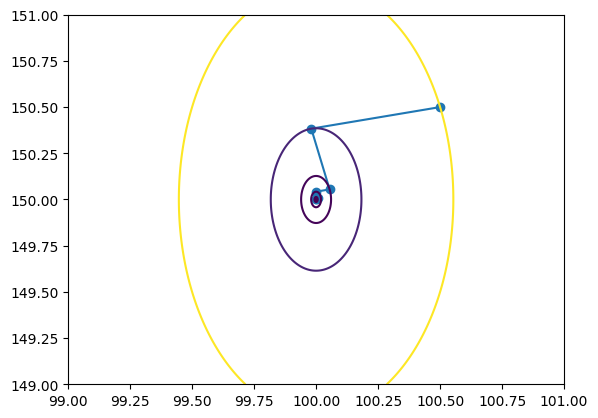

In [421]:
test(second_function, linear_search_gradient_descent, LINEAR_GRADIENT_DESCENT_NAME, [99, 101], [149, 151], real_minimum=REAL_MINIMUM, start_point=CLOSE_POINT)

Linear gradient descent. Start point is [300 350], finish point is [100. 150.], diff with real minimum [ 0. -0.], using scale = 1. Function calls count = 440. Gradient calls count = 11


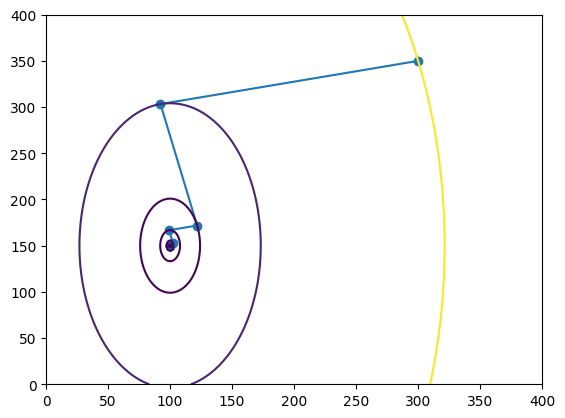

In [422]:
test(second_function, linear_search_gradient_descent, LINEAR_GRADIENT_DESCENT_NAME, [0, 400], [0, 400], real_minimum=REAL_MINIMUM,
     start_point=FAR_POINT)

### Выводы по сближению/удалению

Видно, что и для второй функции отдаление точки увеличивает кол-во подсчётов градиента, а сближение - уменьшает

Constant gradient descent. Start point is [3.63066442 6.84036683], finish point is [134.16 150.  ], diff with real minimum [ 0.  38.2], using scale = 0.7453559924999299. Function calls count = 0. Gradient calls count = 54


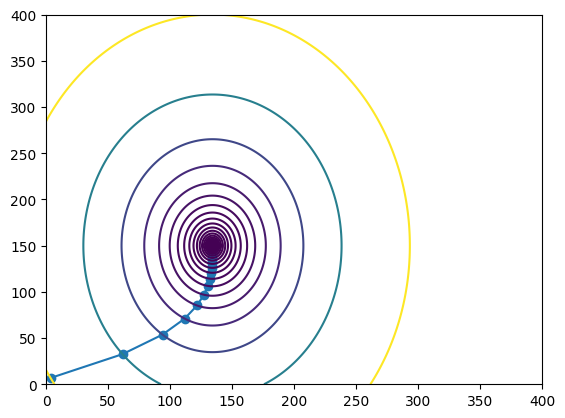

In [423]:
test(second_function, constant_gradient_descent, CONSTANT_GRADIENT_DESCENT_NAME, [0, 400], [0, 400], additional=NORMALIZING_WORD, x_scale=np.sqrt(5/9), constant_step=0.1, real_minimum=REAL_MINIMUM)

Linear gradient descent. Start point is [3.63066442 6.84036683], finish point is [134.16 150.  ], diff with real minimum [-0.  38.2], using scale = 0.7453559924999299. Function calls count = 440. Gradient calls count = 11


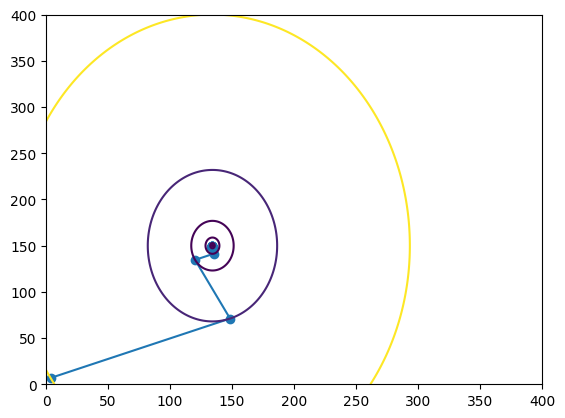

In [424]:
test(second_function, linear_search_gradient_descent, LINEAR_GRADIENT_DESCENT_NAME, [0, 400], [0, 400], additional=NORMALIZING_WORD, x_scale=np.sqrt(5 / 9), real_minimum=REAL_MINIMUM)

## Третья функция

$f_3(x, y)=(x + y)^2 = x^2 + 2xy + y^2$

Минимум достигается в $(-1, 1)$ (либо в любых других точках, где $x = -y$)

Число обусловленности = $\frac{2}{0}=+\infty$

In [425]:
THIRD_FUNCTION_MINIMUM_X = np.array([-1, 1])


@clever
def third_function(x):
    return x[0] ** 2 + 2 * x[0] * x[1] + x[1] ** 2


init_function(third_function, THIRD_FUNCTION_MINIMUM_X, 3)

Constant gradient descent. Start point is [3.63066442 6.84036683], finish point is [-1.6  1.6], diff with real minimum [ 0.6 -0.6], using scale = 1. Function calls count = 0. Gradient calls count = 300


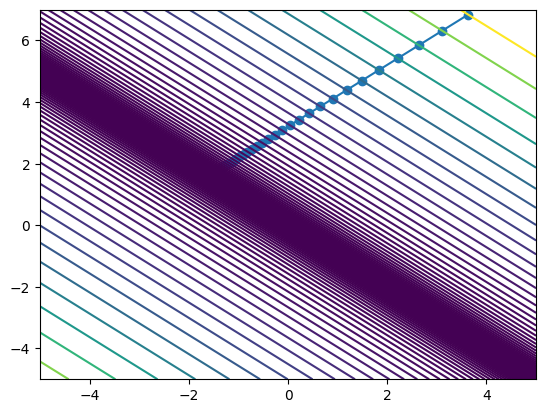

In [428]:
test(third_function, constant_gradient_descent, CONSTANT_GRADIENT_DESCENT_NAME, [-5, 5], [-5, 7],  constant_step=0.025)

Linear gradient descent. Start point is [3.63066442 6.84036683], finish point is [-1.6  1.6], diff with real minimum [ 0.6 -0.6], using scale = 1. Function calls count = 12000. Gradient calls count = 300


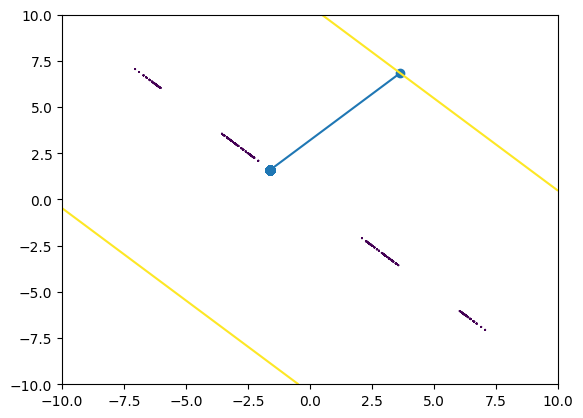

In [430]:
test(third_function, linear_search_gradient_descent, LINEAR_GRADIENT_DESCENT_NAME, [-10, 10], [-10, 10])

Constant gradient descent. Start point is [-0.5  1.5], finish point is [-1.  1.], diff with real minimum [-0. -0.], using scale = 1. Function calls count = 0. Gradient calls count = 55


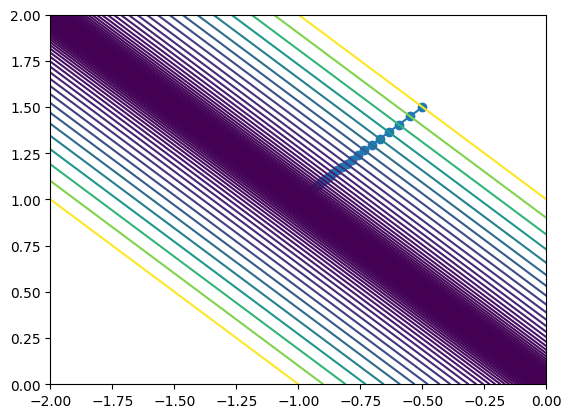

In [432]:
test(third_function, constant_gradient_descent, CONSTANT_GRADIENT_DESCENT_NAME, [-2, 0], [0, 2], constant_step=0.025,
     real_minimum=REAL_MINIMUM, start_point=CLOSE_POINT)

Constant gradient descent. Start point is [199 201], finish point is [-1.  1.], diff with real minimum [-0. -0.], using scale = 1. Function calls count = 0. Gradient calls count = 112


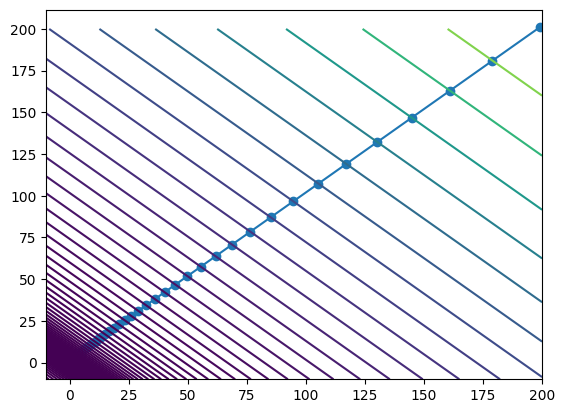

In [434]:
test(third_function, constant_gradient_descent, CONSTANT_GRADIENT_DESCENT_NAME, [-10, 200], [-10, 200], constant_step=0.025,
     real_minimum=REAL_MINIMUM, start_point=FAR_POINT)

Linear gradient descent. Start point is [-0.5  1.5], finish point is [-1.  1.], diff with real minimum [-0. -0.], using scale = 1. Function calls count = 40. Gradient calls count = 1


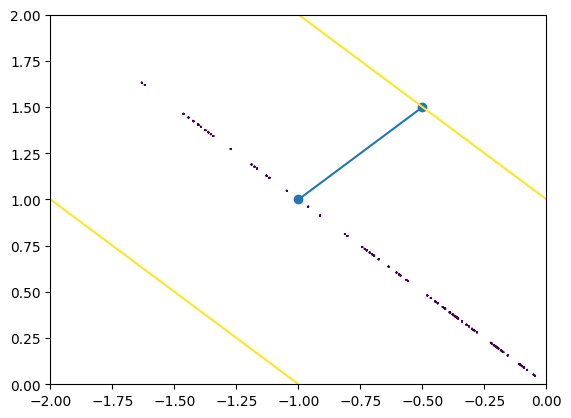

In [435]:
test(third_function, linear_search_gradient_descent, LINEAR_GRADIENT_DESCENT_NAME, [-2, 0], [0, 2], real_minimum=REAL_MINIMUM,
     start_point=CLOSE_POINT)

Linear gradient descent. Start point is [199 201], finish point is [-1.  1.], diff with real minimum [-0.  0.], using scale = 1. Function calls count = 40. Gradient calls count = 1


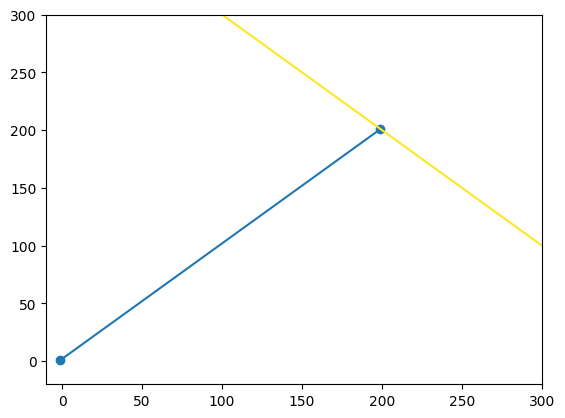

In [438]:
test(third_function, linear_search_gradient_descent, LINEAR_GRADIENT_DESCENT_NAME, [-10, 300], [-20, 300], real_minimum=REAL_MINIMUM,
     start_point=FAR_POINT)

Constant gradient descent. Start point is [3.63066442 6.84036683], finish point is [-4.75  4.75], diff with real minimum [ 8.49 -8.49], using scale = 2. Function calls count = 0. Gradient calls count = 300


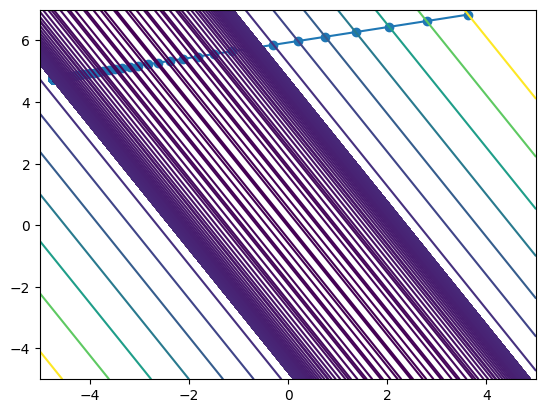

In [439]:
test(third_function, constant_gradient_descent, CONSTANT_GRADIENT_DESCENT_NAME, [-5, 5], [-5, 7], additional=NORMALIZING_WORD,
     x_scale=2, constant_step=0.01, real_minimum=REAL_MINIMUM)

Linear gradient descent. Start point is [3.63066442 6.84036683], finish point is [-2.64  5.27], diff with real minimum [ 4.27 -9.55], using scale = 2. Function calls count = 40. Gradient calls count = 1


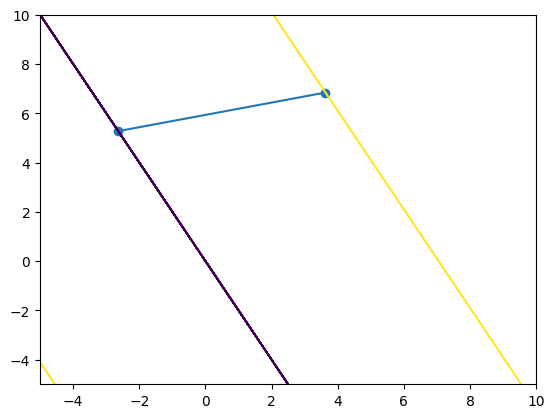

In [441]:
test(third_function, linear_search_gradient_descent, LINEAR_GRADIENT_DESCENT_NAME, [-5, 10], [-5, 10], additional=NORMALIZING_WORD,
     x_scale=2, real_minimum=REAL_MINIMUM)

## Общие выводы
1. Градиентный спуск с постоянным шагом сходится не всегда, градиентный спуск на методе Фибоначчи сошелся во всех случаях
2. Удаление точки для всех методов и всех функций увеличивает кол-во вычислений
3. Нормализация сильно ускоряет градиентный спуск. Например, во второй функции для градиентного спуска без нормализации 300 вычислений градиента, а с нормализацией 54. 

# 5. Реализуйте генератор случайных квадратичных функций n переменных с числом обусловленности k.

## Генерация случайных квадратичных функций

Определение числа обусловленности квадратичной функции заключается в нахождении максимального значения выражения $\frac{\frac{\Delta x}{x}}{\frac{\Delta y}{y}}$ для уравнения $f(x)=y$, где $x$ - решение уравнения $f(t)=y$, а $x+\Delta x$ - решение $f(t)=y+\Delta y$.

Для функции $f(x) = \frac{1}{2}x^TAx - b^Tx$, где $A$ - диагональная матрица с положительными элементами на диагонали, мы хотим найти число обусловленности для функции $f$ как для задачи поиска точки минимума ${\arg\min\limits_{x}f(x)}$.
Для этого найдем равносильное уравнение, то есть такую функцию $g$ и точку $t$, что ${g(x)=t\iff x=\arg\min\limits_{h}f(h)}$.
Минимум функции $f(x)$ достигается при условии $\forall k$ $x_k=\frac{b_k}{a_k}$, что эквивалентно уравнению $Ax=b$.

Рассмотрим линейное уравнение $Ax=b$, где $A$ - ограниченный обратимый линейный оператор $\mathbb{R}^n\to\mathbb{R}^n$, $b\in\mathbb{R}^n$.
Тогда по определению число обусловленности уравнения $\kappa=\max\limits_{\Delta b, b\neq0}\left[\frac{\frac{\Delta x}{x}}{\frac{\Delta b}{b}}\right]=\max\limits_{\Delta b\neq0}\frac{A^{-1}\Delta b}{\Delta b}\cdot\max\limits_{x\neq0}\frac{Ax}{x}=\Vert A^{-1}\Vert\cdot\Vert A\Vert=\frac{\lambda_{max}}{\lambda_{min}}$, где $\lambda_{max}$ и $\lambda_{min}$ - наибольший и наименьший собственные значения матрицы $A$ соответственно.

Таким образом, для функции $f(x) = \frac{1}{2}x^TAx - b^Tx$, где $A$ - диагональная матрица с положительными элементами на диагонали, число обусловленности равно $\frac{\lambda_{max}}{\lambda_{min}}$, что представляет собой отношение наибольшего элемента на диагонали матрицы к наименьшему.

Для получения необходимого значения $\kappa$ можно сгенерировать диагональную матрицу с элементами $d_i$ - случайными числами от $1$ до $\kappa$, таким образом, чтобы существовали $d_a = 1$ и $d_b = \kappa$. Вектор $b$ можно заполнить случайными числами.

In [443]:
from tqdm.notebook import tqdm  # для progress бара

Добавим рандом:

In [444]:
random_generator = np.random.default_rng(seed=RANDOM_SEED)

Создадим функцию для генерации диагональной матрицы:

In [445]:
def get_diagonal_of_matrix(dim_count, max_value):
    diagonal = random_generator.choice(np.arange(1, max_value),
                                       size=dim_count)  # просто генерируем вектор из случайных чисел необходимой размерности

    (one_id, max_value_id) = random_generator.choice(dim_count, size=2,
                                                     replace=False)  # replace=False, тк не хотим выбрать один и тот же индекс
    diagonal[one_id] = 1  # гарантируем 1
    diagonal[max_value_id] = max_value  # гарантируем max_value

    return diagonal

Используя функцию для генерации случайной диагонали матрицы, создадим требуемую в задании функцию:

In [446]:
def create_random_function_and_gradient(dim_count, cond_number):
    diagonal = get_diagonal_of_matrix(dim_count, cond_number)
    x_coeffs = random_generator.random(dim_count)

    def random_function(x):
        y = x ** 2

        return y.dot(diagonal) / 2 - x.dot(x_coeffs)  
        # a_1 * (x_1)^2 / 2 + a_2 * (x_2)^2 + ... - b_1 * x_1 - b_2 * x_2 - ...

    def random_gradient(x):
        return x * diagonal - x_coeffs  
        # (a_1 * (x_1)^2 / 2 + a_2 * (x_2)^2 / 2 + ... - b_1 * x_1 - b_2 * x_2 - ...)' = a_1 * x_1 + a_2 * x_2 + ... - b_1 - b_2 - ...

    return random_function, random_gradient, random_function(x_coeffs / diagonal)

Хотим нарисовать это и не забыть отображение прогресса (довольно долго считается)

In [447]:
K_FROM = 2
K_TO = 1000


def plot_graphic(linear_search_type, dims_count, checks_number, iteration_count=5, progress_bar=False):
    kappas = np.linspace(K_FROM, K_TO, checks_number, dtype=int)

    if progress_bar:
        ks = tqdm(kappas)
    else:
        ks = kappas

    results = []
    for k in ks:
        result = 0

        for _ in range(iteration_count):
            function, gradient_function, min_value = create_random_function_and_gradient(dims_count, k)
            result += len(linear_search_type(function, dims_count, gradient_function=gradient_function,
                                             start_point=np.random.rand(dims_count), iteration_count=5000,
                                             real_minimum=min_value))

        results.append(result / iteration_count)
    plt.plot(kappas, results, '-o')

# 6. Исследуйте зависимость числа итераций $T(n,k)$, необходимых градиентному спуску для сходимости в зависимости от размерности пространства $2 ≤ n ≤ 10^3$ и числа обусловленности оптимизируемой функции $1 ≤ k ≤ 10^3$.

## Снова рисуем графики

Для исследования зависимости количества итераций, необходимых для сходимости градиентного спуска, от числа обусловленности $\kappa$ при фиксированной размерности пространства $n$, мы напишем тестовую функцию. В этой функции мы будем строить график, отображающий изменение количества итераций в зависимости от значения $\kappa$. Для получения более точных результатов, мы будем повторять каждую проверку несколько раз и усреднять полученные значения. Количество повторений одной проверки будет задаваться аргументом iteration_count.

In [448]:
FIG_SIZE = (15, 10)
DPI = 100


def plot_graphic_dims(dims_count_list, checks_number, iteration_count, progress_bar=False):
    plt.figure(figsize=FIG_SIZE, dpi=DPI)

    for dim in dims_count_list:
        plot_graphic(linear_search_gradient_descent, dim, checks_number, iteration_count=iteration_count,
                     progress_bar=progress_bar)

    plt.legend(list(map(str, dims_count_list)))

Найдём количество итераций, необходимых градиентному спуску, без усреднения (запуская один раз)

In [449]:
DIMS_TO_CHECK = [2, 3, 5, 10, 50, 100, 300, 500, 1000]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

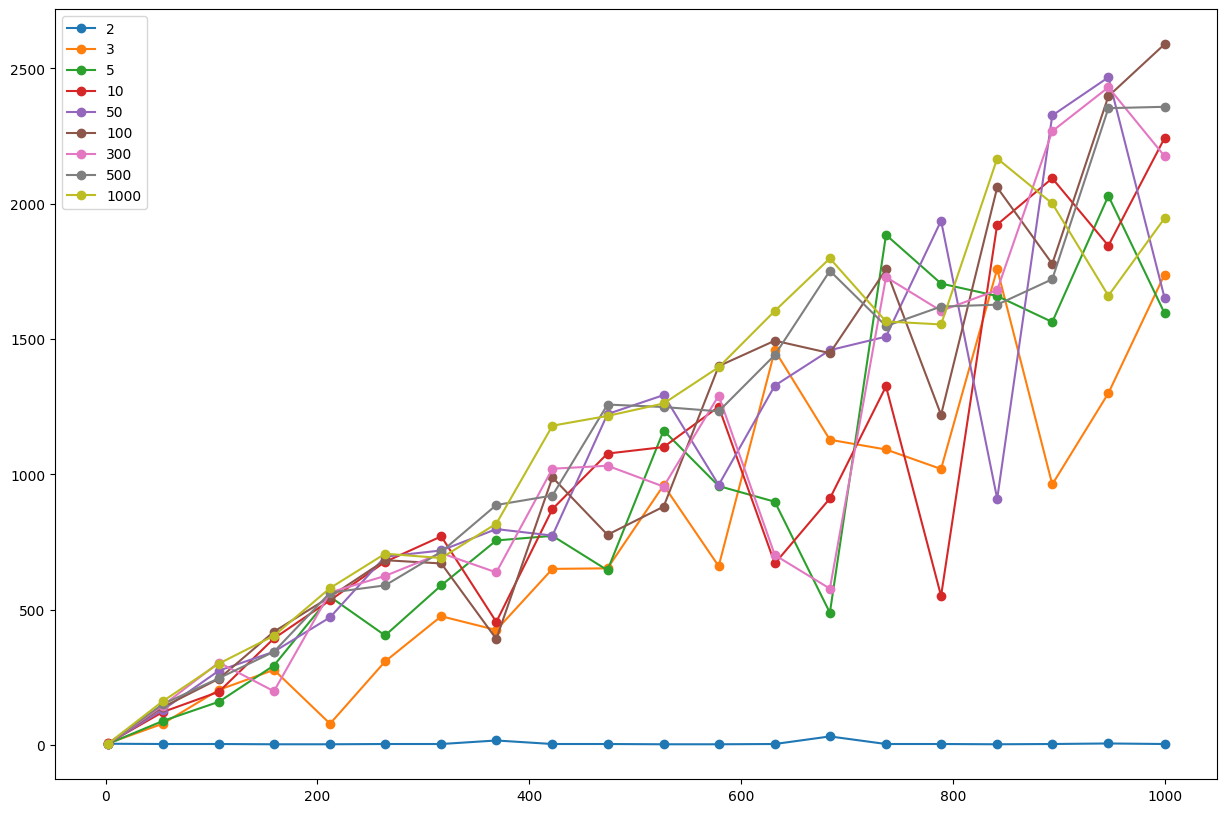

In [450]:
plot_graphic_dims(DIMS_TO_CHECK, 20, iteration_count=1, progress_bar=True)

# 7. Для получения более корректных результатов проведите множественный эксперимент и усредните полученные значения числа итераций.

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

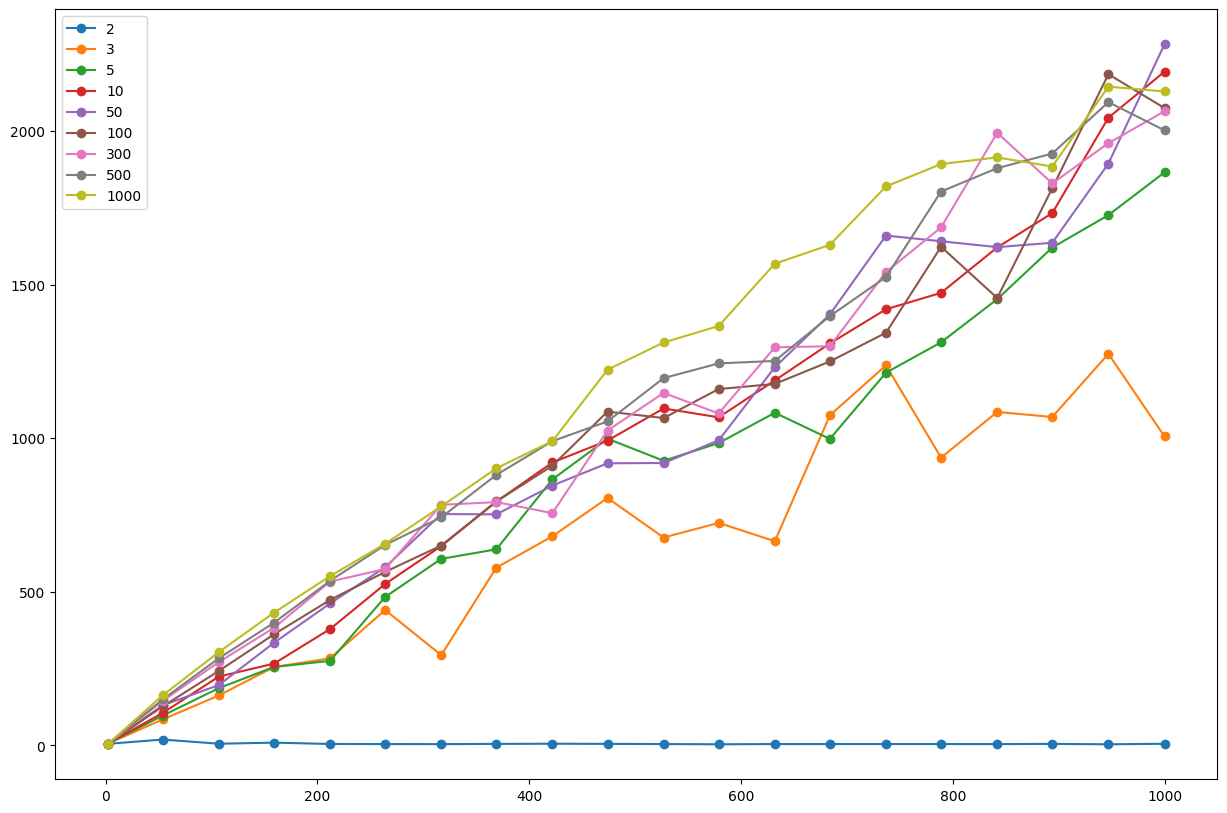

In [451]:
plot_graphic_dims(DIMS_TO_CHECK, 20, 10, progress_bar=True)

Как ожидалось, в условиях постоянной размерности, количество шагов увеличивается при росте $\kappa$. При повышении числа обусловленности функции изменения происходят быстрее, и требуется дополнительное время для схождения алгоритма. Графики для различных размерностей (помимо двойки, график которой ведёт себя как константа в силу малой размерности и простоты поиска минимума) не проявляют значительных различий, однако в среднем, при фиксированном значении $\kappa$, требуется больше итераций при более высоких размерностях.

# 8. Реализуйте одномерный поиск с учетом условий Вольфе и исследуйте его эффективность. Сравните полученные результаты с реализованными ранее методами.

Реализовали метод одномерного поиска, основанный на усиленных условиях Вольфе. Для этого используется встроенный метод line_search из scipy.optimize.

Градиентный спуск с линейным поиском в условиях Вольфе – это метод оптимизации, который используется для нахождения минимума (или максимума) функции. Он основан на использовании градиента функции, который показывает направление наискорейшего возрастания функции.

Алгоритм градиентного спуска с линейным поиском в условиях Вольфе состоит из следующих шагов:

1. Инициализация начальной точки x0 и выбор значения параметра alpha (также называемого learning rate), который определяет шаг обновления.

2. Вычисление градиента функции в текущей точке xk.

3. Выбор направления движения, которое определяется как противоположное направлению градиента (-grad(f(xk))).

4. Выполнение линейного поиска для определения оптимального значения alpha. Линейный поиск заключается в поиске значения alpha, которое удовлетворяет условиям Вольфе

5. Обновление текущей точки $x_{k+1} = x_k - alpha * grad(f(x_k))$.

6. Повторение шагов 2-5 до достижения критерия остановки, например, заданного количества итераций или достижения требуемой точности.

Градиентный спуск с линейным поиском в условиях Вольфе является эффективным методом оптимизации, который позволяет находить минимум функции с использованием информации о ее градиенте. Он широко применяется в машинном обучении и других областях, где требуется решение задач оптимизации.

Усиленные условия Вольфе включают два неравенства:
$$f(x_k + \alpha_kp_k) \leq f(x_k) + c_1\alpha_k\nabla f_k^Tp_k$$
$$|\nabla f(x_k + \alpha_kp_k)^Tp_k| \leq c_2|\nabla f_k^Tp_k|$$

, где $0 < c_1 < c_2 < 1$

Константа $c_1$ должна быть достаточно маленькой (в окрестности 0), чтобы после шага функция уменьшилась, в то время как $c_2$ должна быть большой (в окрестности 1), чтобы проекция градиента уменьшилась по модулю.

Можно доказать, что если $p_k$ - направление убывания для ограниченной снизу и непрерывно дифференциируемой функции $f$, каждый шаг $\alpha _{k}$ удовлетворяет условиям Вольфе, а градиент функции $f$ непрерывен по Липшицу:
$$\forall x, \tilde{x} \; \nabla f(x) - \nabla f(\tilde{x}) \leq L||x - \tilde{x}$$
то
$$\sum_{k \geq 0} \cos^2 \theta_k||\nabla f_k^2 < \infty$$
где
$$\cos \theta_k = -\frac{\nabla f_k^Tp_k}{\nabla f_kp_k} $$
Это означает, что $\cos^2 \theta_k||\nabla f_k||^2$ стремится к 0 при $k \rightarrow \infty$, что гарантирует сходимость алгоритма.

Импортируем встроенную функцию line_search:

In [452]:
from scipy.optimize import line_search

Простая функция для проверки 1-го условия Вольфе:

In [453]:
def is_Volfe_function(function, x, alpha, h, c1, grad):
    return function(x + alpha * h) <= function(x) + c1 * alpha * np.dot(grad(x), h)

Напишем сам поиск:

In [454]:
ALPHA_START = 1.0
C_1 = 1e-4


def linear_Volfe_search(function, x, h, interval, gradient_function=None):
    grad = get_gradient_function(function, gradient_function)

    h *= interval

    result_line_search = line_search(function, grad, x, h)

    if result_line_search[0] is None:
        c1 = C_1
        alpha = ALPHA_START

        while is_Volfe_function(function, x, alpha, h, c1, grad):
            alpha /= 2

    else:
        return x + result_line_search[0] * h

    return x + alpha * h

### Градиентный спуск с линейным поиском в условиях Вольфе

In [455]:
LINEAR_VOLFE_GRADIENT_DESCENT_NAME = "Linear Volfe gradient descent"


def linear_Volfe_gradient_descent(function, dim_count, gradient_function=None, start_point=None, iteration_count=60,
                                  real_minimum=0):
    return abstract_linear_search(linear_Volfe_search, function, dim_count, gradient_function, start_point=start_point,
                                  iteration_count=iteration_count, real_minimum=real_minimum)

### Первая функция

In [456]:
init_function(first_function, FIRST_FUNCTION_MINIMUM_X, 1)

Linear Volfe gradient descent. Start point is [3.63066442 6.84036683], finish point is [0. 0.], diff with real minimum [-0. -0.], using scale = 1. Function calls count = 18. Gradient calls count = 12


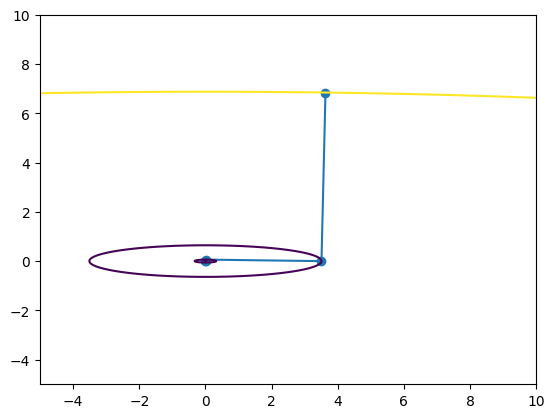

In [460]:
test(first_function, linear_Volfe_gradient_descent, LINEAR_VOLFE_GRADIENT_DESCENT_NAME, [-5, 10], [-5, 10], real_minimum=REAL_MINIMUM)

### Первая функция с начальной точкой дальше от минимума

Linear Volfe gradient descent. Start point is [200 200], finish point is [0. 0.], diff with real minimum [-0. -0.], using scale = 1. Function calls count = 36. Gradient calls count = 24


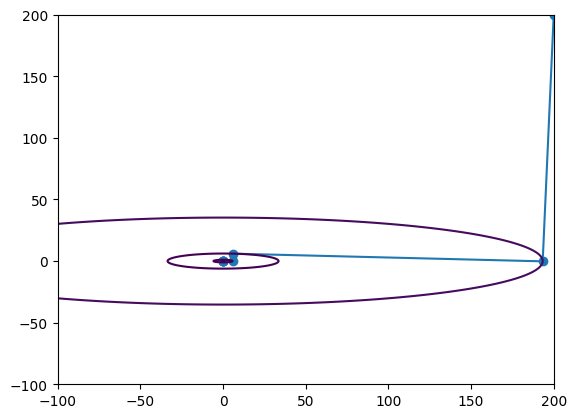

In [462]:
test(first_function, linear_Volfe_gradient_descent, LINEAR_VOLFE_GRADIENT_DESCENT_NAME, [-100, 200],[-100, 200], additional=START_POINT_WORD, start_point=FAR_POINT, real_minimum=REAL_MINIMUM)

### Вторая функция

In [463]:
init_function(second_function, SECOND_FUNCTION_MINIMUM_X, 2)

Linear Volfe gradient descent. Start point is [3.63066442 6.84036683], finish point is [100. 150.], diff with real minimum [0. 0.], using scale = 1. Function calls count = 42. Gradient calls count = 42


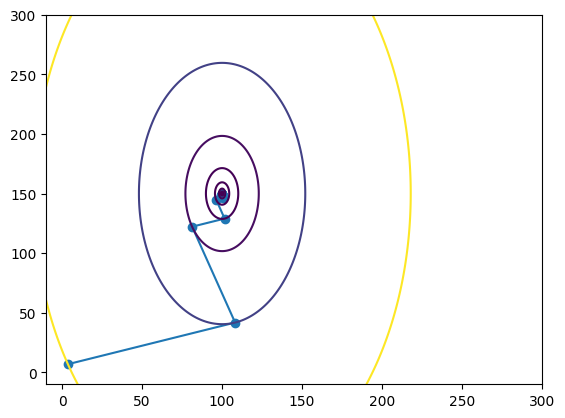

In [464]:
test(second_function, linear_Volfe_gradient_descent, LINEAR_VOLFE_GRADIENT_DESCENT_NAME, [-10, 300], [-10, 300], real_minimum=REAL_MINIMUM)

### Третья функция

In [465]:
init_function(third_function, THIRD_FUNCTION_MINIMUM_X, 3)

Linear Volfe gradient descent. Start point is [3.63066442 6.84036683], finish point is [-1.6  1.6], diff with real minimum [ 0.6 -0.6], using scale = 1. Function calls count = 3. Gradient calls count = 3


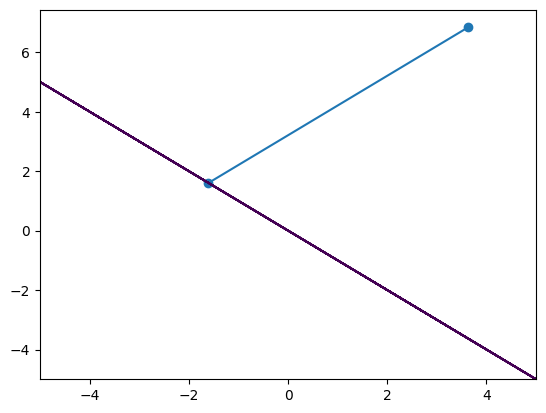

In [466]:
test(third_function, linear_Volfe_gradient_descent, LINEAR_VOLFE_GRADIENT_DESCENT_NAME, [-5, 5],[-5, 5], real_minimum=REAL_MINIMUM)

### Табличка с итоговыми результатами для сравнения

In [473]:
df.loc[df['Linear search type'] == 'Linear gradient descent']

,Function,Linear search type,Addition,Function calls,Gradient calls,Summary calls
1,1,Linear gradient descent,,160,4,176
4,1,Linear gradient descent,,160,4,176
5,1,Linear gradient descent,,320,8,352
11,1,Linear gradient descent,Normalising,40,1,44
12,1,Linear gradient descent,Normalising,40,1,44
14,2,Linear gradient descent,,1160,30,1280
18,2,Linear gradient descent,,240,6,264
19,2,Linear gradient descent,,240,6,264
20,2,Linear gradient descent,,440,11,484
38,2,Linear gradient descent,Normalising,440,11,484


In [477]:
df.loc[df['Linear search type'] == 'Linear Volfe gradient descent']

,Function,Linear search type,Addition,Function calls,Gradient calls,Summary calls
82,1,Linear Volfe gradient descent,,18,12,66
83,1,Linear Volfe gradient descent,,18,12,66
84,1,Linear Volfe gradient descent,,18,12,66
85,1,Linear Volfe gradient descent,Choose start point,36,24,132
86,1,Linear Volfe gradient descent,Choose start point,36,24,132
87,2,Linear Volfe gradient descent,,42,42,210
88,3,Linear Volfe gradient descent,,3,3,15


In [476]:
df

,Function,Linear search type,Addition,Function calls,Gradient calls,Summary calls
0,1,Constant gradient descent,,0,107,428
1,1,Linear gradient descent,,160,4,176
2,1,Constant gradient descent,,0,99,396
3,1,Constant gradient descent,,0,216,864
4,1,Linear gradient descent,,160,4,176
...,...,...,...,...,...,...
84,1,Linear Volfe gradient descent,,18,12,66
85,1,Linear Volfe gradient descent,Choose start point,36,24,132
86,1,Linear Volfe gradient descent,Choose start point,36,24,132
87,2,Linear Volfe gradient descent,,42,42,210


### Эффективность условий Вольфе

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

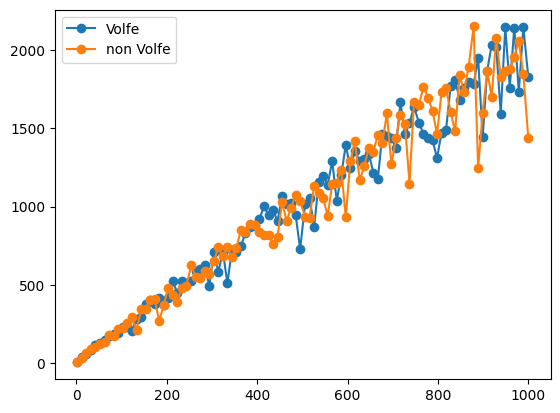

In [468]:
plot_graphic(linear_Volfe_gradient_descent, 100, 100, progress_bar=True)

plot_graphic(linear_search_gradient_descent, 100, 100, progress_bar=True)

plt.legend(["Volfe", "non Volfe"])

### Выводы об эффективности
При анализе тестовых функций можно заметить, что использование условий Вольфе приводит к сокращению количества вычислений функции:
1. $160/18 \approx 9$
2. $240/42 \approx 6$
3. $40/3 \approx 13$

Также стоит отметить, что применение данных условий положительно влияет на количество вычислений функции при удалении начальной точки от минимума - оно уменьшается почти в 5 раз по сравнению с обычным линейным поиском.

Однако следует отметить, что использование условий Вольфе приводит к более частым вычислениям градиента:
1. $12/4 \approx 3$
2. $42/30 \approx 1.5$
3. $3/1 \approx 3$

Если рассмотреть общее количество вычислений, то оно сокращается в
1. $176/66 \approx 3$
2. $1280/210 \approx 6$
3. $44/15 \approx 3$

После проведения множественных экспериментов с усреднением результатов и построением графика было выявлено, что графики количества вычислений в зависимости от числа обусловленности ведут себя одинаково в пределах погрешности.

Таким образом, можно сделать вывод, что использование условий Вольфе может оптимизировать градиентный спуск для некоторых специальных функций, однако в общем случае нельзя гарантировать улучшение эффективности.